In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.style.use("ggplot")
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 14

import numpy as np

from ars_247_2025_final_project.models import TRAM_Model, Transcriptional_Delay_Model, Stress_Model
from ars_247_2025_final_project.tools import gaussian_pulse, geometric_ou_noise, gaussian_pulse

In [2]:
HOUR = 3600
MINUTE = 60
# transcriptional pulse
transcriptional_pulse = {
    'peak_time': 1.5 * HOUR,
    'peak_value': 1,
    'width': 0.5 * HOUR
}

# phosphorylation pulse
phosphorylation_pulse = {
    'peak_time': 1.5 * HOUR // 4,
    'peak_value': 1,
    'width': 0.5 * HOUR // 4 # 45 mins peak phosphorylation pulse
}

# optogenetic pulse
optogenetic_pulse = {
    'peak_time': 1.5 * HOUR // 10, # peak at 9 mins
    'peak_value': 1,
    'width': 0.5 * HOUR // 10 # 3 mins peak activity of pulse
}

og_tram_params = {
    'PROM': 1,
    'V_A': 0.47, #um/s - mean for dynein / kinesin
    'R_M': 2.5, #um - mean for mammalian cells is 2.5; best results w/ 20
    'K_TEV': 0.015, #/s - physiological is ~0.15
    'K_TVMV': 0.015, #/s - physiological is ~0.15
    'K_TRAM_DEG': 0.00001, #/s - got interesting results with this being 0.01; physiological is ~0.00001
    'K_TF_DEG': 0.01 #/s - got interesting results with this being 0.1; physiological is ~0.01 w/ fast degron
}

og_td_params = {
    'PROM': 1,
    'K_D': 75,
    'N_COOP': 2,
    'K_DEG': 0.005
}

tram_params = og_tram_params.copy()

In [3]:
tram_model = TRAM_Model(
    n_delays=8,
    pulse='gaussian',
    pulse_params=optogenetic_pulse,
    sys_config=tram_params
)

In [4]:
td_model = Transcriptional_Delay_Model(
    n_delays = 8,
    pulse = 'gaussian',
    pulse_params = optogenetic_pulse,
    sys_config = og_td_params
)

In [5]:
tram_model.solve_model_ivp(t_start=0, t_end=HOUR, sys_input=None)
td_model.solve_model_ivp(t_start=0, t_end=HOUR, sys_input=None)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [   0    1 ... 3598 3599]
        y: [[ 0.000e+00  1.117e-02 ...  1.561e-04  1.554e-04]
            [ 0.000e+00  7.368e-09 ...  5.825e-04  5.796e-04]
            ...
            [ 0.000e+00  0.000e+00 ...  9.099e-01  9.054e-01]
            [ 0.000e+00  0.000e+00 ...  3.112e+00  3.097e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 296
     njev: 0
      nlu: 0

(0.0, 5400.0)

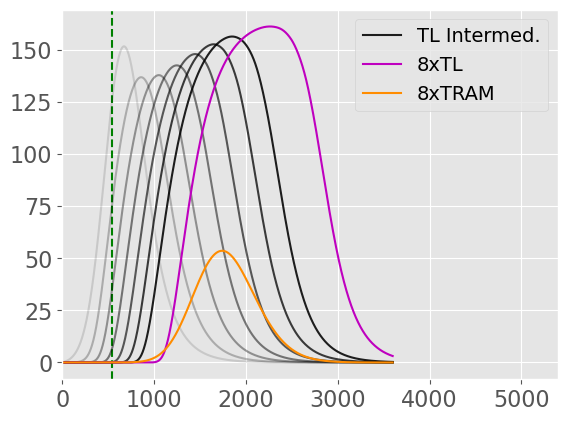

In [6]:
max_input_time = np.argmax([gaussian_pulse(t, **optogenetic_pulse) for t in td_model.soln['t']])
plt.axvline(max_input_time, c="green", linestyle='--')
for ddx in range(td_model.n_delays - 1):
    this_alpha = (ddx / td_model.n_delays) + (1 / td_model.n_delays)
    # plt.plot(tram_model.soln['t'], tram_model.soln['y'][ddx * 4], alpha=this_alpha)
    this_label = "TL Intermed." if ddx == td_model.n_delays - 2 else ""
    plt.plot(td_model.soln['t'], td_model.soln['y'][ddx], color = 'k', alpha=this_alpha, label=this_label)
plt.plot(td_model.soln['t'], td_model.soln['y'][-1], color='m', label='8xTL')
plt.plot(tram_model.soln['t'], tram_model.soln['y'][-1], color='darkorange', label='8xTRAM')
plt.legend()
plt.xlim(0,1.5*HOUR)

In [7]:
# optogenetic pulse
optogenetic_pulse_hour0 = {
    'peak_time': 1.5 * HOUR // 10, # peak at 9 mins
    'peak_value': 1,
    'width': 0.5 * HOUR // 10 # 3 mins peak activity of pulse
}

# optogenetic pulse
optogenetic_pulse_hour2 = {
    'peak_time': 1 * HOUR, # peak at 9 mins
    'peak_value': 1,
    'width': 0.5 * HOUR // 10 # 3 mins peak activity of pulse
}

# optogenetic pulse
optogenetic_pulse_hour4 = {
    'peak_time': 2 * HOUR, # peak at 9 mins
    'peak_value': 1,
    'width': 0.5 * HOUR // 10 # 3 mins peak activity of pulse
}

# optogenetic pulse
optogenetic_pulse_hour4bit = {
    'peak_time': 2 * HOUR - HOUR // 30, # peak at 9 mins
    'peak_value': 1,
    'width': 0.5 * HOUR // 10 # 3 mins peak activity of pulse
}

In [8]:
np.random.seed(14) # 5050 was good
these_k_d_params = {
    'mu': 75,
    'sigma': 15
}
td_model_mism = Transcriptional_Delay_Model(
    n_delays = 8,
    pulse = 'gaussian',
    pulse_params = optogenetic_pulse,
    sys_config = og_td_params,
    random_k_d = True,
    k_d_params = these_k_d_params
)

In [9]:
# Constants
HOUR = 3600
TOTAL_TIME = 3 * HOUR
OU_T_STEP = 20   # Time step size (needs to be small for SDEs)
DT = 1

# SOLVING PULSES PEAK TIMES
hse1_peak_time = np.argmax([gaussian_pulse(t,**optogenetic_pulse_hour0) for t in np.arange(0, TOTAL_TIME, DT)])
hse2_peak_time = np.argmax([gaussian_pulse(t,**optogenetic_pulse_hour4) for t in np.arange(0, TOTAL_TIME, DT)])
are1_peak_time = np.argmax([gaussian_pulse(t,**optogenetic_pulse_hour2) for t in np.arange(0, TOTAL_TIME, DT)])
are2_peak_time = np.argmax([gaussian_pulse(t,**optogenetic_pulse_hour4bit) for t in np.arange(0, TOTAL_TIME, DT)])

# NOISE GENERATION
hse_t, hse_noise = geometric_ou_noise(theta=0.01, sigma=0.02, mu=0.0, t_total=TOTAL_TIME, dt_sde=OU_T_STEP, dt_output=DT) # green
are_t, are_noise = geometric_ou_noise(theta=0.01, sigma=0.02, mu=0.0, t_total=TOTAL_TIME, dt_sde=OU_T_STEP, dt_output=DT) # magenta

# COMBINING SIGNAL AND NOISE
# pHSE
hse = gaussian_pulse(np.arange(TOTAL_TIME), **optogenetic_pulse_hour0)
hse[2*HOUR - 10*MINUTE: 2*HOUR + 10*MINUTE] = gaussian_pulse(np.arange(2*HOUR - 10*MINUTE, 2*HOUR + 10*MINUTE), **optogenetic_pulse_hour4)
hse += hse_noise

# pHRE
are = gaussian_pulse(np.arange(TOTAL_TIME), **optogenetic_pulse_hour2)
are[2*HOUR - 20*MINUTE: 2*HOUR + 10*MINUTE] = gaussian_pulse(np.arange(2*HOUR - 20*MINUTE, 2*HOUR + 10*MINUTE), **optogenetic_pulse_hour4bit)
are += are_noise

# SYNTHESIZING NOISE & DELAYS
# 8xTRAM_model
tram_model.solve_model_ivp(t_start=0, t_end=TOTAL_TIME, sys_input=are)
are_tram = tram_model.soln['y'][-1]
tram_model.solve_model_ivp(t_start=0, t_end=TOTAL_TIME, sys_input=hse)
hse_tram = tram_model.soln['y'][-1]

# 8xTD_model (perfect matching)
td_model.solve_model_ivp(t_start=0, t_end=TOTAL_TIME, sys_input=are)
are_td = td_model.soln['y'][-1]
td_model.solve_model_ivp(t_start=0, t_end=TOTAL_TIME, sys_input=hse)
hse_td = td_model.soln['y'][-1]

# 8xTD_model_mis (mismatched k_ds matching)
td_model_mism.solve_model_ivp(t_start=0, t_end=TOTAL_TIME, sys_input=are)
are_tdm = td_model_mism.soln['y'][-1]
td_model_mism.solve_model_ivp(t_start=0, t_end=TOTAL_TIME, sys_input=hse)
hse_tdm = td_model_mism.soln['y'][-1]

In [10]:
stress_sys_config_tram = {
    'K_TX': 0.005,
    'N_COOP': 2,
    'K_DEG': 0.005,
    'K_D': 25,
    'K_D_DOWN': 0.2
}
stress_sys_config_tdm = {
    'K_TX': 0.005,
    'N_COOP': 2,
    'K_DEG': 0.005,
    'K_D': 60,
    'K_D_DOWN': 0.2
}

stress_tram = Stress_Model(
    input1=are_tram,
    input2=hse_tram,
    n_delays=8,
    pulse = 'gaussian',
    pulse_params = optogenetic_pulse,
    sys_config=stress_sys_config_tram,
    input_names=['hse', 'are'],
    model_type='are_hse',
)
stress_tdmm = Stress_Model(
    input1=are_tdm,
    input2=hse_tdm,
    n_delays=8,
    pulse = 'gaussian',
    pulse_params = optogenetic_pulse,
    sys_config=stress_sys_config_tdm,
    input_names=['hse', 'are'],
    model_type='are_hse',
)

stress_tram.solve_model_ivp(
    t_start=0, t_end=TOTAL_TIME,
    y0 = np.array([0] * 6 + [2] * 3 + [0] * 3)
    # y0 = np.array([0,0,0,0,1,1,0,1,0,0])
)
stress_tdmm.solve_model_ivp(
    t_start=0, t_end=TOTAL_TIME,
    y0 = np.array([0] * 6 + [2] * 3 + [0] * 3)
    # y0 = np.array([0,0,0,0,1,1,0,1,0,0])
)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [    0     1 ... 10798 10799]
        y: [[ 0.000e+00  0.000e+00 ...  7.589e-01  7.592e-01]
            [ 0.000e+00  0.000e+00 ...  4.577e-02  4.556e-02]
            ...
            [ 0.000e+00  4.095e-10 ...  2.150e-01  2.157e-01]
            [ 0.000e+00  4.963e-05 ...  1.259e-01  1.255e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 554
     njev: 0
      nlu: 0

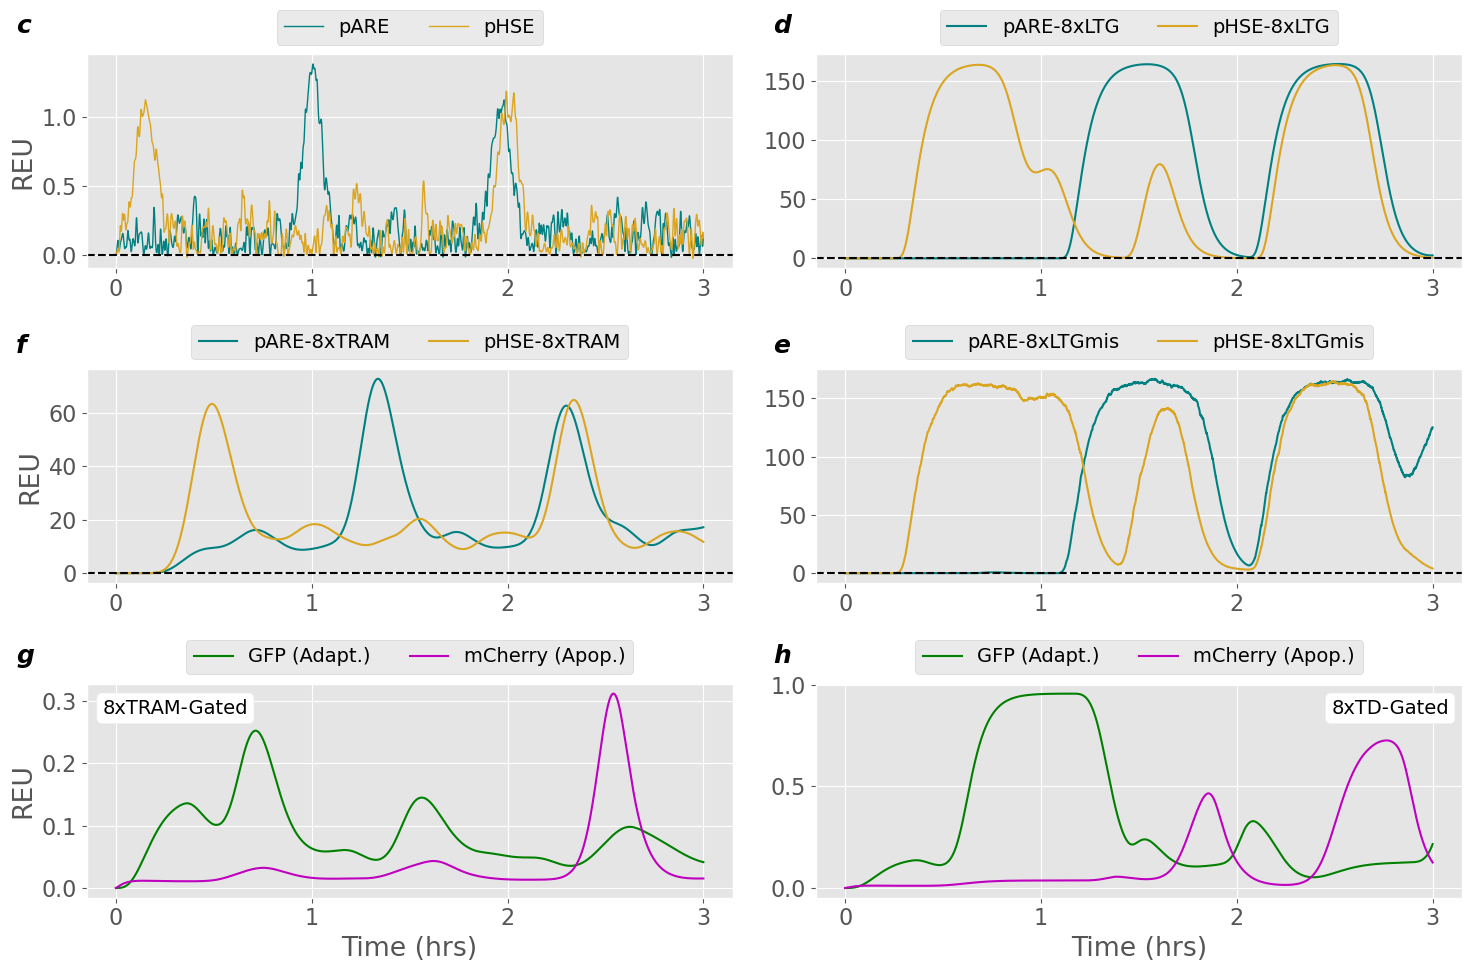

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(321)
ax3 = fig.add_subplot(322)
ax2 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

ax1.plot(np.arange(0, TOTAL_TIME, DT), are, color='teal', label='pARE', linewidth=1)
ax1.plot(np.arange(0, TOTAL_TIME, DT), hse, color='goldenrod', label='pHSE', linewidth=1)
ax1.axhline(0, color='k', linestyle='--')
ticks = np.arange(0, ax1.get_xlim()[1], HOUR)
ticktype = int
ax1.set_xticks(ticks)
ax1.set_xticklabels((ticks / HOUR).astype(ticktype))
ax1.set_ylabel("REU")
ax1.legend(ncols=3, bbox_to_anchor=(0.5,1), loc='lower center')

ax2.plot(tram_model.soln['t'], are_tram, color='teal', label='pARE-8xTRAM')
ax2.plot(tram_model.soln['t'], hse_tram, color='goldenrod', label='pHSE-8xTRAM')
ax2.legend()
ax2.axhline(0, color='k', linestyle='--')
ax2.set_xticks(ticks)
ax2.set_xticklabels((ticks / HOUR).astype(ticktype))
ax2.legend(ncols=2, bbox_to_anchor=(0.5,1), loc='lower center')
ax2.set_ylabel("REU")

ax3.plot(td_model.soln['t'], are_td, color='teal', label='pARE-8xLTG')
ax3.plot(td_model.soln['t'], hse_td, color='goldenrod', label='pHSE-8xLTG')
ax3.legend()
ax3.axhline(0, color='k', linestyle='--')
ax3.set_xticks(ticks)
ax3.set_xticklabels((ticks / HOUR).astype(ticktype))
ax3.legend(ncols=2, bbox_to_anchor=(0.5,1), loc='lower center')

ax4.plot(td_model.soln['t'], are_tdm, color='teal', label='pARE-8xLTGmis')
ax4.plot(td_model.soln['t'], hse_tdm, color='goldenrod', label='pHSE-8xLTGmis')
ax4.legend()
ax4.axhline(0, color='k', linestyle='--')
ax4.set_xticks(ticks)
ax4.set_xticklabels((ticks / HOUR).astype(ticktype))
ax4.legend(ncols=2, bbox_to_anchor=(0.5,1), loc='lower center')

ax5.plot(stress_tram.soln['t'], stress_tram.soln['y'][-2], color='green', label="GFP (Adapt.)")
ax5.plot(stress_tram.soln['t'], stress_tram.soln['y'][-1], color='m', label="mCherry (Apop.)")
ax5.legend(ncols=2, bbox_to_anchor=(0.5,1), loc='lower center')
ax5.annotate('8xTRAM-Gated', xy=(0.025, 0.93), xycoords='axes fraction',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))
ax5.set_xticks(ticks)
ax5.set_xticklabels((ticks / HOUR).astype(ticktype))
ax5.legend(ncols=2, bbox_to_anchor=(0.5,1), loc='lower center')
ax5.set_ylabel("REU")
ax5.set_xlabel("Time (hrs)")

ax6.plot(stress_tram.soln['t'], stress_tdmm.soln['y'][-2], color='green', label="GFP (Adapt.)")
ax6.plot(stress_tram.soln['t'], stress_tdmm.soln['y'][-1], color='m', label="mCherry (Apop.)")
ax6.set_xticks(ticks)
ax6.set_xticklabels((ticks / HOUR).astype(ticktype))
ax6.annotate('8xLTG-Gated', xy=(0.98, 0.93), xycoords='axes fraction',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
ax6.legend(ncols=2, bbox_to_anchor=(0.5,1), loc='lower center')
ax6.set_xlabel("Time (hrs)")

fig.text( # panel c
    x=0.02, y=0.96, s="c",
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=18, fontweight='bold', style='italic'
)
fig.text( # panel d
    x=0.525, y=0.96, s="d",
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=18, fontweight='bold', style='italic'
)
fig.text( # panel f
    x=0.02, y=0.64, s="f",
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=18, fontweight='bold', style='italic'
)
fig.text( # panel e
    x=0.525, y=0.64, s="e",
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=18, fontweight='bold', style='italic'
)
fig.text( # panel g
    x=0.02, y=0.33, s="g",
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=18, fontweight='bold', style='italic'
)
fig.text( # panel h
    x=0.525, y=0.33, s="h",
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=18, fontweight='bold', style='italic'
)

plt.tight_layout()

In [12]:
td_model_mism._get_k_ds(8)

array([59.94440414, 88.21910542, 71.51898461, 92.33375499, 67.45225962,
       64.63620236, 74.75329891, 59.07369897])